# Road accidents prediction

In this notebook we will try to predict the number of road accidents based on traffic and social media usage.

The first step is to import matplotlib and set the style for plots.

In [3]:
%matplotlib inline
import numpy
from pylab import *

style.use("giovanni")

<hr style="height: .1em"/>


## Datasets

We are using data about traffic and accidents from seven major italian cities. These data have been made available as part of the [Telecom Italia Big Data Challenge 2015](telecomitalia.com/tit/en/bigdatachallenge.html). We consider rectangular grids with fixed resolution $r = 10^{-4}\,^\circ$.

In [4]:
cities = ['bari', 'milano', 'napoli', 'palermo', 'roma', 'torino', 'venezia']
location = 'gfs'
boxes_location = 'data'
store_location = 'data'
scale = 1000.0

These functions load the raw data and store them in a convenient HDF store.

In [5]:
import os
import pandas
import tarfile
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers[0].setFormatter(logging.Formatter('%(asctime)s: %(message)s'))

locations = {
    'gfs': '/l/cnets/datasets/Telecom_BDC_2015',
    'diskstation': '/media/diskstation/Datasets/Telecom Big Data Challenge 2015',
    'data': os.path.expanduser('~/data/tbdc15'),
    'hdd': '/media/giovanni/Multimedia/Datasets/Telecom Big Data Challenge 2015',
    'repo': os.path.expanduser('~/repos/tbdc15')
}


def getpaths(city, loc='gfs', boxesloc=None, storeloc=None):
    root = locations[loc]
    city_codes = {'RO': 'RM'}
    code = city[:2].upper()
    if code in city_codes:
        code = city_codes[code]
    paths = {
        'trips': '{root}/infoblu/{city}.tar.gz'.format(root=root, city=city),
        'accidents': '{root}/unipol/BDC2015_UnipolsaiClaims2014_{city}.csv'.format(root=root, city=code),
        'boxes': '{root}/city_boxes.csv'.format(root=root if boxesloc is None else locations[boxesloc]),
        'store': '{root}/trip_accidents_store.hdf'.format(root=root if storeloc is None else locations[storeloc]),
        'tweets': '{root}/tweets/tweets_{city}.dat'.format(root=root, city=code[0].lower())
    }
    return paths


def getbox(path, city):
    city_code = city[0].lower()
    df_box = pandas.read_csv(path, index_col='city')
    df_box.ix[city_code]
    box = df_box.ix[city_code].to_dict()
    return box


def read_tweets(path, box, scale=1000.0):
    df = pandas.read_csv(path, sep=' ', names=['lat', 'lon', 'tweets'])
    df['i'] = ((df['lat'] - box['lat_min']) * scale).round()
    df['j'] = ((df['lon'] - box['lon_min']) * scale).round()
    return df.set_index(['i', 'j']).filter(['tweets'])


def read_trips(path, box, scale=1000.0, break_at=None):
    index_columns = ['i', 'j', 'weekday', 'hour']
    trips = pandas.DataFrame(columns=index_columns + ['trips', 'trips_start']).set_index(index_columns)

    # set break_at to an integer and it will stop exactly after that number of iterations
    i = 0

    with tarfile.open(path, mode='r:gz') as tf:
        # open tar file in random access mode with on-the-fly gzip decompression
        for member in tf:
            if break_at is not None and i == break_at:
                break
            i += 1

            # read contents of TAR archive. Each file in the archive contains 
            # the data of a different day.
            logger.info(member.name)
            f = tf.extractfile(member)

            # do not use the "type" and "speed" columns, since we don't need them. This saves memory.
            df = pandas.read_csv(f, 
                                 names=['trip', 'timestamp', 'lat', 'lon', 'type', 'speed'],
                                 usecols=['trip', 'timestamp', 'lat', 'lon', 'speed'],
                                 sep=';', 
                                 parse_dates=['timestamp'])

            # compute the cell, weekday, and hour
            df['i'] = ((df['lat'] - box['lat_min']) * scale).round()
            df['j'] = ((df['lon'] - box['lon_min']) * scale).round()
            df['weekday'] = df['timestamp'].map(pandas.Timestamp.weekday)
            df['hour'] = df['timestamp'].map(lambda k: k.hour)

            # count how many trips in each cell, weekday, hour and append. 
            # Note that the first group-by returns a series object, 
            # and we wrap this into a DataFrame.        
            s1 = df.groupby(index_columns).agg({'trip': 'size', 'speed': 'mean'})
            s1.rename(columns={'trip': 'trips'}, inplace=True)

            # do the same but only considering the first frame of each trip.
            df_ff = df.groupby('trip', as_index=False).head(1)
            s2 = df_ff.groupby(index_columns).agg({'trip': 'size'})
            s2.rename(columns={'trip': 'trips_start'}, inplace=True)

            df = s1.join(s2)
            
            trips = trips.append(df)

    return trips


def read_accidents(path, box, scale=1000.0):
    index_columns = ['i', 'j', 'weekday', 'hour']    
    df = pandas.read_csv(path)
    df.rename(columns={'day_type': 'weekday', 'time_range': 'hour'}, inplace=True)
    df['i'] = ((df['latitude'] - box['lat_min']) * scale).round()
    df['j'] = ((df['longitude'] - box['lon_min']) * scale).round()
    s = df.groupby(index_columns).apply(len)
    accidents = pandas.DataFrame({'accidents': s})
    return accidents


def make_city_frame(city, 
                    loc='frosty', 
                    boxesloc='frosty',
                    storeloc='frosty',
                    scale=1000.0, 
                    break_at=None):
    """
    Reads data of trips and accidents and store data frame into HDF format
    """
    paths = getpaths(city, loc=location, boxesloc=boxesloc, storeloc=storeloc)
    box = getbox(paths['boxes'], city)
    logger.info("Reading trips...")
    trips = read_trips(paths['trips'], box, scale=scale, break_at=break_at)
    logger.info("Reading accidents...")
    accidents = read_accidents(paths['accidents'], box, scale=scale)
    logger.info("Storing data...")
    joined_df = trips.join(accidents).fillna(0).reset_index()
    joined_df.to_hdf(paths['store'], city, complib='blosc', complevel=6)
    logger.info("Data saved to HDF:".format(paths['store']))

### Read the data 

This will generate an HDFS store with all the data. If you need to _regenerate_ a new store from scratch, you need to remove the file, since by default the store is opened in append mode. To remove the file, you can use the cell below, which is by default set in text mode. Use `C-M y` to make the cell executable.

rm -f /u/gciampag/data/tbdc15/trip_accidents_store.hdf

Run this cell to create a new HDF store with all data.

__Warning!__: executing this cell will take time!

In [32]:
for city in cities:
    logging.info("City: {}".format(city))
    make_city_frame(city, 
                    loc=location, 
                    scale=scale, 
                    boxesloc=boxes_location,
                    storeloc=store_location, 
                    break_at=None)

2015-12-11 19:52:21,910: City: bari
2015-12-11 19:52:21,919: Reading trips...
2015-12-11 19:52:21,930: output_20150301_BARI.txt
2015-12-11 19:53:54,164: output_20150302_BARI.txt
2015-12-11 19:55:48,799: output_20150303_BARI.txt
2015-12-11 19:57:51,981: output_20150304_BARI.txt
2015-12-11 19:59:55,508: output_20150305_BARI.txt
2015-12-11 20:01:57,246: output_20150306_BARI.txt
2015-12-11 20:03:56,935: output_20150307_BARI.txt
2015-12-11 20:05:58,906: output_20150308_BARI.txt
2015-12-11 20:07:33,000: output_20150309_BARI.txt
2015-12-11 20:09:36,232: output_20150310_BARI.txt
2015-12-11 20:11:39,481: output_20150311_BARI.txt
2015-12-11 20:13:25,670: output_20150312_BARI.txt
2015-12-11 20:15:05,136: output_20150313_BARI.txt
2015-12-11 20:17:08,719: output_20150314_BARI.txt
2015-12-11 20:19:36,838: output_20150315_BARI.txt
2015-12-11 20:21:32,815: output_20150316_BARI.txt
2015-12-11 20:24:10,213: output_20150317_BARI.txt
2015-12-11 20:26:45,849: output_20150318_BARI.txt
2015-12-11 20:29:19,22

Also compute the totals on the full observation window. This takes less time than the above.

In [69]:
def weighted_mean(x, w):
    return (x * w).sum() / w.sum()

for city in cities:
    paths = getpaths(city, loc=location, boxesloc=boxes_location, storeloc=store_location)
    df = pandas.read_hdf(paths['store'], city)
    grouped = df.groupby(['i', 'j'])
    df_sums = grouped.sum().filter(['trips', 'trips_start', 'accidents'])
    df_wmea = grouped.apply(lambda grp: weighted_mean(grp['speed'], grp['trips']))
    df = df_sums.join(pandas.DataFrame({'speed': df_wmea}))
    df.to_hdf(paths['store'], '/totals/{}'.format(city))
    logger.info("Completed: {}".format(city))

2015-12-12 14:48:28,688: Completed: bari
2015-12-12 14:52:18,361: Completed: milano
2015-12-12 14:55:09,364: Completed: napoli
2015-12-12 14:55:54,805: Completed: palermo
2015-12-12 15:00:24,907: Completed: roma
2015-12-12 15:03:15,617: Completed: torino
2015-12-12 15:04:35,504: Completed: venezia


<hr style="height: .1em"/>


## Methods 

### Zero-inflated Geometric Distribution 

The geometric distribution with support starting at 0 is the distribution of number of failures $k$ before the first success in a series of Bernoulli trials each with success probability $p$: 

$$\Pr\left(k\,; p\right) = p\left(1 - p\right)^k $$

The zero-inflated model is a mixture of a process generating zeros with fixed probability $\pi$, and a normal geometric process. That is, for each observation first we toss a coin and with probability $\pi$ produce a zero, otherwise we draw from the Geometric distribution: 

$$
\Pr\left(k\,; \pi, p\right) = 
\begin{cases}
\pi + \left(1 - \pi\right) p & \text{if } k = 0\\
\left(1 - \pi\right) p\left(1 - p\right)^k & \text{if }k > 0\\
\end{cases}
$$

In general, given a discrete distribution with $n$ parameters and p.m.f. $p(k; \theta_1, \ldots, \theta_n)$, then zero-inflated version has p.m.f.:

$$
\Pr\{x\,; \pi, \theta_1, \ldots, \theta_n\} = 
\begin{cases}
\pi + \left(1 - \pi\right) p(k; \theta_1,\ldots,\theta_n) & \text{if } k = 0\\
\left(1 - \pi\right)  p(k; \theta_1,\ldots,\theta_n) & \text{if }k > 0\\
\end{cases}
$$

In [4]:
import numpy
from scipy.stats import rv_discrete
from scipy.optimize import minimize

    
class MLEFitMixin(object):
    """
    Add Maximum Likelihood Estimation `fit()` method to discrete random variate classes 
    """
    
    def _fitstart(self, data):
        """
        Provide an initial guess of the parameters for the numerical optimization. 
        
        You *should* override this.
        """
        raise NotImplementedError("please implement this!")
    
    @classmethod
    def fit(cls, data, fast=True, **kwargs):
        """ 
        Maximum Likelihood parameter estimation by numeric optimization. 
        Uses the Nelder-Mead downhill simplex algorithm to minimize 
        the negative log-likelihood function of the model.
        
        Parameters
        ----------
        data : array_like
        
        fast : bool 
            If true, will compute the log-likehood of the data using a 
            contingency table. This should speed up the calculations.
        
        Notes
        -----
        Additional keyword arguments (exlc. `method`) are passed to `scipy.optimize.minimize`.
        Raises RuntimeError if minimum is not found.
        """
        def _nllk(args, weights=None):
            l = - _rv(*args).logpmf(data)
            if weights is not None:
                return numpy.sum(weights * l)
            else:
                return l.sum()
        _rv = cls()
        x0 = _rv._fitstart(data)
        kwargs.pop('method', None)  # make sure user does not override method
        if fast:
            data = np.asarray(data)
            dmin = data.min()
            dmax = data.max()
            weights, edges = numpy.histogram(data, bins=dmax - dmin + 1, range=(dmin, dmax + 1))
            data = edges[:-1]
            args = (weights,)
        else:
            args = ()
        ret = minimize(_nllk, x0, method='Nelder-Mead', args=args, **kwargs)
        if ret['success']:
            return ret['x']
        else:
            raise RuntimeError(ret['message'])

    
class zigeom_gen(rv_discrete, MLEFitMixin):
    extradoc = r"""
    Zero-inflated Geometric distribution (with support starting at k = 0)
    
    \Pr\left(k\,; p, \pi\right) = 
    \begin{cases}
        \pi + \left(1 - \pi\right) p & \text{if } k = 0\\
        \left(1 - \pi\right) p\left(1 - p\right)^k & \text{if }k > 0\\
    \end{cases}
    """
    
    def _fitstart(self, data):
        N = float(len(data))
        pi0 = (data == 0).sum() / N
        x0 = (pi0, .5)
        return x0
        
    
    def _pmf(self, k, pi, p):
        # using ufuncs -- no need to vectorize explicity
        s = numpy.sign(k)
        return (1 - s) * (pi + (1.0 - pi) * p) + s * (1.0 - pi) * (1.0 - p) ** k * p

    
from scipy.stats import poisson
    
class zipoisson_gen(rv_discrete, MLEFitMixin):
    def _fitstart(self, data):
        N = float(len(data))
        pi0 = (data == 0).sum() / N
        mu0 = data.mean()
        return (pi0, mu0)
    
    def _pmf(self, k, pi, mu):
        p = (1 - pi) * poisson._pmf(k, mu)
        return np.where(k == 0, p + pi, p)
        
            
zigeom = zigeom_gen(name='zigeom', longname='Zero-inflated Geometric', extradoc=zigeom_gen.extradoc)
zipoisson = zipoisson_gen(name='zipoisson', longname='Zero-inflated Poisson')

# Quick test of the grouping

data = zigeom(.3, .3).rvs(10)
p1 = zigeom.fit(data)
p2 = zigeom.fit(data, fast=False)
assert numpy.allclose(p1, p2), "Approximation does not work!"

Let $\theta = \left(\pi, p\right)$ and let $\hat\theta_N$ the MLE estimate for sample size $N$. We test that the estimator is _unbiased_ by checking that, as $N\rightarrow\infty$, the residual $\|\hat\theta_N - \theta\|$ of the fit converges to zero. We do this by simulating from the model.

Please set the `path` first: this variable is needed by the cells below for writing and reading the data to and from disk.

In [388]:
path = '/u/gciampag/data/tbdc15/zigeom_residuals.npz'

__Warning__: executing the next cell will take time!

In [ ]:
numpy.random.seed(0)
pi = .2
p = .3
params = np.array([pi, p])
N = [10, 100, 1000, 10000, 100000]
R = 50  # replicas

data = [zigeom(pi, p).rvs(size=(R, n)) for n in N]
e_params = [np.asarray([zigeom.fit(data[i_n][r]) for r in xrange(R)]) for i_n in xrange(len(N))]
resids = [e_params[i_n] - params for i_n in xrange(len(N))]

numpy.savez_compressed(path, **dict(zip(map(str, N), resids)))
print "Residuals saved to: {}".format(path)

Now we can plot the result using boxplots:

Plot saved to: zigeom_residuals.pdf
Plot saved to: zigeom_residuals.png


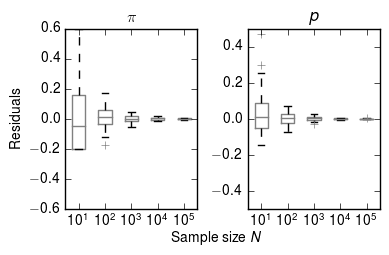

In [454]:
# load the data
npzf = numpy.load(path)
N = sorted(map(int, npzf))
resids = [npzf[str(n)] for n in N]

fig, axs = subplots(ncols=2)

titles = ['$\pi$', '$p$']

def boxplot_panel(ax, i):
    props = {'color': 'k'}
    props2 = {'color': 'gray'}
    props3 = {'color': 'gray'}
    ax.boxplot([resids[i_n][:, i] for i_n in xrange(len(N))], 
               boxprops=props3, 
               flierprops=props2, 
               whiskerprops=props, 
               capprops=props, 
               meanprops=props2, 
               medianprops=props2)
    l = max(numpy.abs(ax.get_ylim()))
    ax.set_ylim(-l, l)
    ax.set_xticklabels(['$10^{:.0f}$'.format(numpy.log10(n)) for n in N])
    ax.set_title(titles[i])


boxplot_panel(axs[0], 0)
boxplot_panel(axs[1], 1)
axs[0].set_ylabel("Residuals")
fig.text(0.55, 0.0, "Sample size $N$", transform=fig.transFigure, horizontalalignment='center')
draw()

for fmt in ['pdf', 'png']:
    figure_path = 'zigeom_residuals.{}'.format(fmt)
    savefig(figure_path)
    print "Plot saved to: {}".format(figure_path)

### Data cleaning

Let us consider the cells with $A = 0$ accidents. According to the zero-inflated assumption, some of these zeros have been "added" to our dataset and we wish to discard them. More precisely, if there are $N$ observations taken from a zero-inflated Geometric distribution, then the number of additional zeros is given by:
$$N_0 = N \frac{(1 - \pi)p}{\pi + (1 - \pi)p}$$
The next step is to select _which_ cells are going to be discarded from our dataset. We consider two methods for performing the selection:

1. __Naive selection__. We just consider a random sample of $N_0$ cells, regardless of the value of other variables.

2. __Covariation-preserving selection__. Let us consider the events $\{A = 0\}$ and $\{T = t\}$. Ideally, if these were two independent events, that is if
  
  $$\Pr\{A = 0, T = t\} = \Pr\{A = 0\}\Pr\{T = t\}$$

  then the naive method above would be the correct method to use. However, in practice we expect $A$ and $T$ to be related to each other, and thus also the two events $\{A = 0\}$ and $\{T = t\}$. We take $N_0$ observations as above, but instead of drawing cells at random, we wish to discard cells so that the association between trips $T$ and accidents $A$ is respected. To do so, we consider the pointwise mutual information (PMI) between a given traffic level $t$ and a given number of accidents $a$:

  $$\mathrm{pmi}(t, a) = \log{\frac{\Pr\{T = t, A = a\}}{\Pr\{T = t\}\cdot \Pr\{A = a\}}} = \log \Pr\{T = t \,|\, A = a\} - \log \Pr\{T = t\}$$
  
  A value of $\mathrm{pmi} > 0$ tell that the two events $\{T = t\}$ and $\{A = a\}$ are more likely to happen than what they would be under independence. Since we are interested in filtering out the cells with $A = 0$, we compute the PMI profile $\mathrm{pmi}_0(t) = \mathrm{pmi}(t, 0)$.
  
  Because the distribution of traffic is heavy tailed, to compute $\mathrm{pmi}_0(t)$ we estimate probabilities by binning values of $T$ using logarithmic binning in base 2. This means that this form of selection can be seen as a form of stratified sampling, where the strata correspond to the number of bins used to estimate the PMI profile. A cell with a given level of traffic $T=t$ is chosen with a weight that is proportional to $w(t) \propto \exp\left(\mathrm{pmi}_0(t)\right)$, up to a normalization factor.
  
The following function compute the pointwise mutual information between traffic and a given level of accidents. 

In [71]:
def pmiat(t, a, value, n=12):
    """
    computes the pointwise mutual information (PMI) between one variable and a pre-specified value of the other.
    Let us consider variables T and A. The pointwise mutual information at values t and a is defined as:
    
        $$\mathrm{pmi}(t, a) = \log \Pr\{T = t \,|\, A = a\} - \log \Pr\{T = t\}$$
        
    This function computes $\mathrm{pmi}(t, a)$ when a is fixed to a specified value. It is assumed that T >= 1.
        
    Parameters
    ----------
    t, a : array_like
    
        Samples for T and A. The arrays must have the same size.
        
    value : int
        
        Value (a)
        
    Returns
    -------
    edges, pmi : array_like
        
        Two arrays. Edges contains N + 1 elements and correspond to the edges of N bins, over the range (0, max(t)). 
        pmi contains the values of the PMI in each bin. Bins are exponentially spaced in base 2.
    """
    edges = numpy.logspace(0, numpy.log2(t.max()), num=n, base=2, endpoint=True)
    t0 = t[a == value]
    h1, __ = numpy.histogram(t, bins=edges, normed=True)
    h0, __ = numpy.histogram(t0, bins=edges, normed=True)
    _pmi = numpy.log(h0) - numpy.log(h1)
    return edges, _pmi

We can now load the cities data and compute the PMI profile of each city

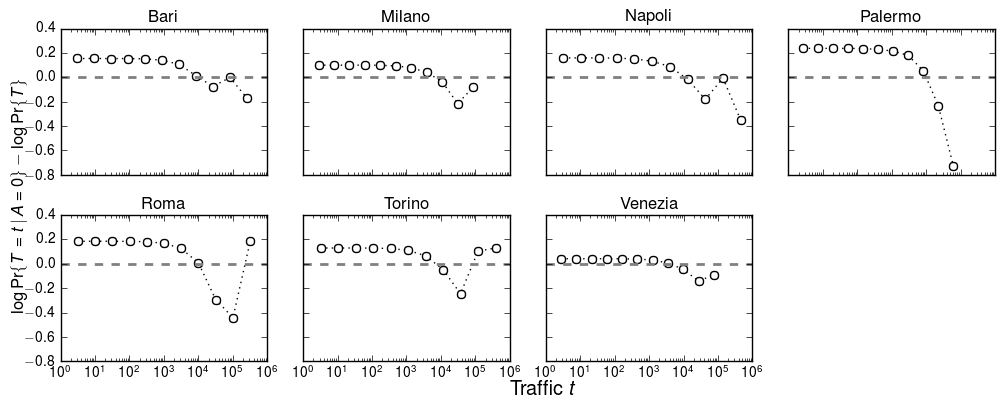

In [82]:
import numpy
from truthy_measure.plotting import plot_pdf_log2, plot_cdf


def plot_pmi(city):
    paths = getpaths(city, loc=location, boxesloc=boxes_location, storeloc=store_location)
    df = pandas.read_hdf(paths['store'], '/totals/{}'.format(city))
    bins, pmi0acc = pmiat(df['trips'].values, df['accidents'].values, 0, n=12)
    plot(bins[1:], pmi0acc, 'ko:', mfc='w', mew=1.)
    axhline(0, ls='--', color='gray', lw=2)
    xscale('log')
    yb = max(numpy.abs(ylim()))
#    ylim(-yb, yb)
    title(city.title())
    tight_layout()

fig, axs = subplots(nrows=2, ncols=4, figsize=(10, 4), sharex=True, sharey=True)
axs1d = numpy.ravel(axs)

for city, ax in zip(cities, axs1d):
    sca(ax)
    plot_pmi(city)

for ax in axs1d[len(cities):]:
    delaxes(ax)

text(0.5, 0, 'Traffic $t$', fontsize='x-large', transform=fig.transFigure)
text(0, 0.5, r'$\log\Pr\{T = t \,|\, A = 0\} - \log\Pr\{T\}$', fontsize='large', rotation=90, 
     transform=fig.transFigure, verticalalignment='center')

tight_layout(pad=2.5, h_pad=0, w_pad=0)

In [39]:
def grouped_data_array(data, group_size):
    data = numpy.ravel(data).copy()
    data = numpy.ceil(data / group_size)
    return data


def clean_data(df, column, method='random', covariate='trips', group_size=None, num_strata=12):
    """
    Cleans data of rows with excess zeroes in a given column. Uses a zero-inflated 
    geometric distribution to estimate the number of additional zeros. Rows with 
    inflated zeros can be removed in one of two ways:
    
        1. Random sampling: just draws the rows to drop at random.
        
        2. Stratified sampling: performs a stratified sampling using the pointwise 
           mutual information with a given covariate.
           
    Parameters
    ----------
    df : pandas.DataFrame
        The data to be cleaned.
        
    column : str
        The name of the column with excess zeroes.
        
    method : str
        Either 'random' (default) or 'strata'
        
    covariate : str
        If covariate sampling is requested, name of the covariate column. Used only if method = 'strata'.
        
    group_size : int > 0
        optional; group the data in bins of this size before estimating the Z.-I. model.
        
    num_strata : int
        optional; default: 12. Number of strata for stratified sampling. Used only if method = 'strata'.
        
    Returns
    -------
    df_cleaned : pandas.DataFrame
        Cleaned data
        
    zgtheta : tuple
        Estimated parameters of the Z.-I. Geometric model.
    """
    if method not in ['random', 'strata']:
        raise ValueError("unknown cleaning method: {}".format(method))
    data = df[column].values
    if group_size is not None:
        if group_size <= 0:
            raise ValueError("group size must be > 0: {}".format(group_size))
        data = grouped_data_array(data, group_size)
    zgtheta = zigeom.fit(data)
    ze_rows = df.query('{} == 0'.format(column))
    nz_rows = df.query('{} > 0'.format(column))
    Nze = len(ze_rows)
    p0 = zigeom(*zgtheta).pmf(0)
    n = numpy.round((((1 - zgtheta[0]) * zgtheta[1]) / p0) * Nze)
    if method == 'random':
        ze_rows_keep = ze_rows.sample(n)
    else: 
        # stratified sampling. Stratum probability is given by PMI with given covariate
        edges, pmi = pmiat(df[covariate].values, df[column].values, 0, num_strata)
        q = numpy.exp(pmi)
        q /= q.sum()
        stratum = numpy.digitize(ze_rows[covariate], edges[:-1]) - 1
        weights = pandas.DataFrame({'weight': q / ze_rows.groupby(stratum).count()[covariate]})
        dfc = ze_rows.copy()
        dfc['stratum'] = stratum
        dfc = dfc.set_index('stratum').join(weights).reset_index()
        w = numpy.asarray(dfc['weight'])
        ze_rows_keep = ze_rows.sample(n, weights=w)
    df_cleaned = pandas.concat([ze_rows_keep, nz_rows])
    return (df_cleaned, zgtheta)

In [76]:
for city in cities:
    paths = getpaths(city, loc=location, boxesloc=boxes_location, storeloc=store_location)
    df = pandas.read_hdf(paths['store'], '/totals/{}'.format(city))
    df_cleaned, __ = clean_data(df, 'accidents', method='strata', covariate='trips', group_size=9)
    df_cleaned.to_hdf(paths['store'], '/totals_cleaned/{}'.format(city))
    logger.info("Cleaned: {}".format(city))

2015-12-12 15:08:10,153: Cleaned: bari
2015-12-12 15:08:10,931: Cleaned: milano
2015-12-12 15:08:11,529: Cleaned: napoli
2015-12-12 15:08:11,866: Cleaned: palermo
2015-12-12 15:08:12,633: Cleaned: roma
2015-12-12 15:08:13,271: Cleaned: torino
2015-12-12 15:08:13,804: Cleaned: venezia


In [81]:
cleaned_size = {}

for city in cities:
    paths = getpaths(city, loc=location, boxesloc=boxes_location, storeloc=store_location)
    df = pandas.read_hdf(paths['store'], '/totals/{}'.format(city))
    df_cleaned = pandas.read_hdf(paths['store'], '/totals_cleaned/{}'.format(city))
    cleaned_size[city] = float(len(df_cleaned)) / len(df) * 100
pandas.DataFrame({'cleaned_size': cleaned_size})

,cleaned_size
bari,7.452907
milano,11.149020
napoli,17.454780
palermo,8.263439
roma,10.884388
torino,7.901881
venezia,9.238846


In [78]:
from itertools import cycle

def plot_accidents_vs_trips(hdfpath):
    ax = gca()
    xcol = 'trips'
    ax.set_color_cycle(['LightGray', 'gray', 'DarkGray', 'Black'])
    linestyles = cycle([''])
    markers = cycle('+x.')

    for m, ls, city in zip(markers, linestyles, cities):
        df = pandas.read_hdf(paths['store'], '{}/{}'.format(hdfpath, city))
        emin = numpy.log10(df[xcol].min())
        emax = numpy.log10(df[xcol].max())
        bins = numpy.logspace(max(emin, 0), emax, 20)
        df.groupby(numpy.digitize(df[xcol], bins=bins)).mean().plot(x=xcol, y='accidents', ax=ax,
                                                                    linestyle=ls, marker=m,
                                                                    label=city.title())

    legend(loc='best', frameon=False, fontsize='small')
    xscale('log')
    xlabel("Traffic $t$")
    ylabel("Accidents $a$")
    ylim(-2, ylim()[1])
    tight_layout()

We can now plot the average rate of accidents as a function of the cell traffic 

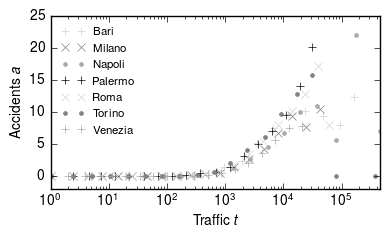

In [79]:
d = '/u/gciampag/data/tbdc15/figures'

plot_accidents_vs_trips("/totals_cleaned")

savefig(os.path.join(d, 'all_cities', "all_cities_cleaned.pdf"))
savefig(os.path.join(d, 'all_cities', "all_cities_cleaned.png"))

In comparison, this is what the same plot looks like on the raw data

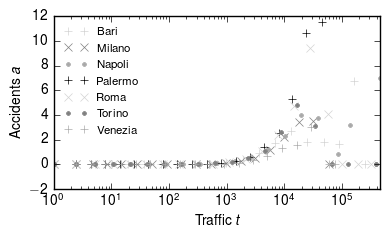

In [80]:
d = '/u/gciampag/data/tbdc15/figures'

plot_accidents_vs_trips("/totals")

savefig(os.path.join(d, 'all_cities', "all_cities_not_cleaned.pdf"))
savefig(os.path.join(d, 'all_cities', "all_cities_not_cleaned.png"))

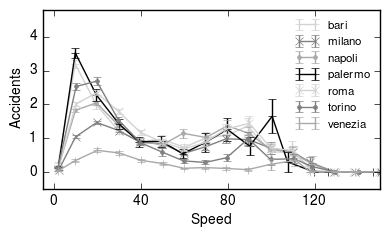

In [165]:
from itertools import cycle

city = 'roma'

ax = gca()
ax.set_color_cycle(['LightGray', 'Gray', 'DarkGray', 'black'])
markers = cycle('+x.')

for m, city in zip(markers, cities):
    paths = getpaths(city, loc='data')
    df = pandas.read_hdf(paths['store'], '/totals_cleaned/{}'.format(city))
    _df = df.groupby((df['speed'] / 10).round()).agg({'accidents': ['mean', 'sem'], 'speed': ['mean', 'sem']})
    errorbar(_df['speed']['mean'], _df['accidents']['mean'], 
             yerr=_df['accidents']['sem'], 
#             xerr=_df['speed']['sem'],
             ls='-',
             marker=m,
             label=city,
            )
legend(loc='best', frameon=False, fontsize='small')
xlim(-5, 150)
ylim(-.5, ylim()[1] * 1.2)
#cbar = colorbar()
#cbar.set_label('Speed (Km/h)')
gca().get_xaxis().set_major_locator(MaxNLocator(5))
xlabel('Speed')
ylabel('Accidents')
#xscale('log')
#title(city.title())

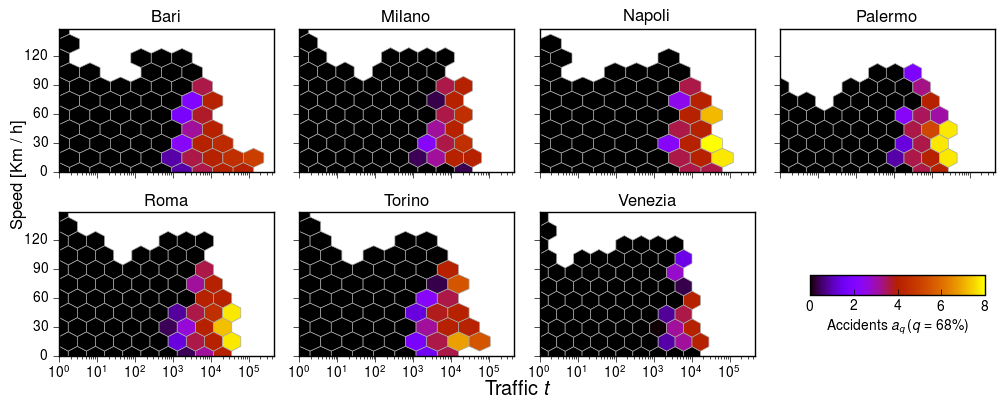

In [302]:

fig, axs = subplots(nrows=2, ncols=4, figsize=(10, 4), sharex=True, sharey=True)
axs1d = numpy.ravel(axs)
mappables = []
max_C = -1
q = 68

for city, ax in zip(cities, axs1d):
    sca(ax)
    paths = getpaths(city, loc='data')
    df = pandas.read_hdf(paths['store'], '/totals_cleaned/{}'.format(city))
    _df = df.query('speed < 150')
    C = _df['accidents']
    mappable = ax.hexbin(_df['trips'], _df['speed'], C=C, xscale='log', cmap='gnuplot', gridsize=10,
                        reduce_C_function=lambda k : percentile(k, q), edgecolor='DarkGray', lw=.5, mincnt=5)
    mappables.append(mappable)
    m = mappable.get_array().max()
    if max_C < m:
        max_C = m
    title(city.title())
    ax.get_yaxis().set_major_locator(MaxNLocator(5))
    ax.tick_params(axis='y', left=True, right=False, direction='out')
    ax.tick_params(axis='x', bottom=True, top=False, direction='out', which='both')
    
n = matplotlib.colors.Normalize(vmin=0, vmax=max_C)
for mappable in mappables:
    mappable.set_norm(n)
    
fig.delaxes(axs1d[-1])
cbar_ax = fig.add_axes([0.8, 0.25, 0.175, 0.05])
cbar = colorbar(mappable, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'Accidents $a_q\, (q = {}\%)$'.format(q))
cbar_ax.get_xaxis().set_major_locator(MaxNLocator(4))
text(0.475, 0, 'Traffic $t$', fontsize='x-large', transform=fig.transFigure)
text(0, 0.55, 'Speed [Km / h]', fontsize='large', rotation=90, 
     transform=fig.transFigure, verticalalignment='center')


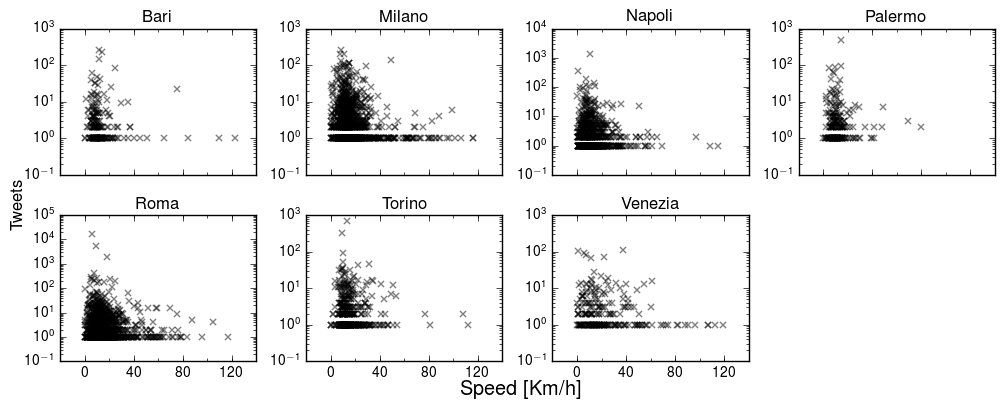

In [363]:
def scatter_speed_tweets(city):
    ax = gca()
    paths = getpaths(city, loc='data')
    box = getbox(paths['boxes'], city)
    tweets = read_tweets(paths['tweets'], box)
    df = pandas.read_hdf(paths['store'], '/totals_cleaned/{}'.format(city))
    df.join(tweets).dropna().plot(x='speed', y='tweets', kind='scatter', ax=ax, marker='x', color='none', 
                                  edgecolor='k', alpha=.5)
#    df = df.join(tweets).dropna()
#    mappable = ax.hexbin(df['speed'], df['tweets'], yscale='log', cmap='gnuplot', gridsize=10, 
#                         edgecolor='DarkGray', lw=.5, mincnt=5)
    
#    scatter(df['speed'], df['tweets'])
    #xscale('log')
    yscale('log')
    xlabel('')
    ylabel('')
    title(city.title())
    
    
fig, axs = subplots(nrows=2, ncols=4, figsize=(10, 4), sharex=True)
axs1d = numpy.ravel(axs)

for city, ax in zip(cities, axs1d):
    sca(ax)
    scatter_speed_tweets(city)

for ax in axs1d[len(cities):]:
    delaxes(ax)

text(0.45, 0, 'Speed [Km/h]', fontsize='x-large', transform=fig.transFigure)
text(0, 0.475, 'Tweets', fontsize='large', rotation=90, 
     transform=fig.transFigure, verticalalignment='center')

axs1d[0].get_xaxis().set_major_locator(MaxNLocator(5))

tight_layout(pad=2.5, h_pad=0, w_pad=0)

### Plotting functions 

These functions are needed for plotting.

In [12]:
# scatter plot
def scatter_trips_accidents(df, city, use_trips_starts=False, ax=None):
    if use_trips_starts:
        xcol = 'trips_start'
    else:
        xcol = 'trips'
        
    if ax is None:
        ax = gca()
        
#    df.plot(x=xcol, y='accidents', kind='scatter', marker='x', alpha=.1, color='k', ax=ax)

    # trend line
    emin = numpy.log10(df[xcol].min())
    emax = numpy.log10(df[xcol].max())
    bins = numpy.logspace(max(emin, 0), emax, 20)
    
    df.groupby(numpy.digitize(df[xcol], bins=bins)).mean().plot(x=xcol, y='accidents',
                                                                color='r', linestyle='solid',
                                                                marker='', ax=ax, alpha=.75, 
                                                                linewidth=2, label='Avg')
    ax.grid('off')
    ax.set_title(city.title())
    if use_trips_starts:
        ax.set_xlabel('Traffic (start of trip)')
    else:
        ax.set_xlabel('Traffic')
    ax.set_ylabel('Accidents')
    ax.set_xscale('log')
    ax.set_xlim(1, ax.get_xlim()[1])
    ax.legend([], frameon=False)


def hist_accidents(city, paths):
    df = pandas.read_hdf(paths['store'], '/totals/{}'.format(city))
    ax = gca()
    acc_max = df['accidents'].max()
    acc_min = df['accidents'].min()
    bins = acc_max - acc_min + 1
    ax.hist(df['accidents'].values, log=True, bins=bin, range=(acc_min, acc_max), color='white')
    ylim(.1, ylim()[1])
    xlabel('Accidents')
    ylabel('Frequency')
    title(city.title())
    tight_layout()
    savefig('accidents_histogram_{}.pdf'.format(city.replace(" ", "_")))
    savefig('accidents_histogram_{}.png'.format(city.replace(" ", "_")))
    show()
    
    
def plot_all(city):
    paths = getpaths(city, 
                     loc=location, 
                     boxesloc=boxes_location,
                     storeloc=store_location)
    df = pandas.read_hdf(paths['store'], city)
    df = df.groupby(['i', 'j']).sum().filter(['trips', 'trips_start', 'accidents'])
    scatter_trips_accidents(df, city)
    scatter_trips_accidents(df, city, use_trips_starts=True)
    hist_accidents(df, city)

<hr style="height: .1em"/>

## Results

This will make, for each city, a cell-by-cell scatter plot of trips versus accidents and an histogram of the distribution of accidents (i.e. insurance claims).

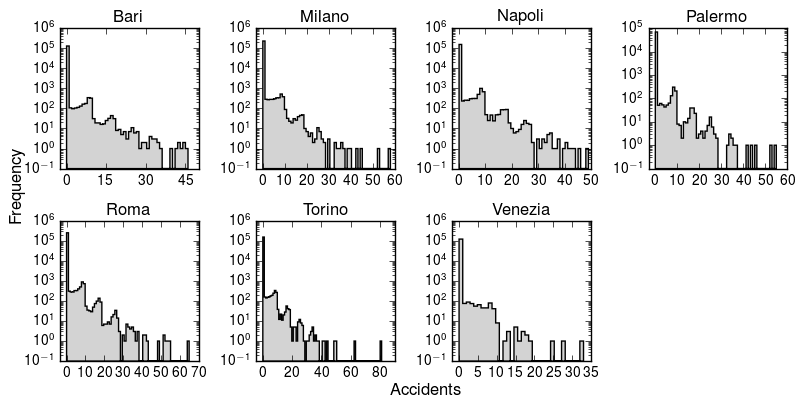

In [37]:
def hist_accidents(city, **kwargs):
    paths = getpaths(city, **kwargs)
    df = pandas.read_hdf(paths['store'], '/totals/{}'.format(city))
    acc_max = df['accidents'].max()
    acc_min = df['accidents'].min()
    bins = acc_max - acc_min + 1
    hist(df['accidents'].values.ravel(), log=True, bins=bins, range=(acc_min, acc_max), 
         edgecolor='black', color='LightGray', histtype='stepfilled')
    ylim(.1, ylim()[1])
    xlim(xlim()[0] - (xlim()[1] - xlim()[0]) / 20.0, xlim()[-1])
    xlabel('Accidents')
    ylabel('Frequency')
    title(city.title())

fig, axs = subplots(nrows=2, ncols=4, figsize=(8, 4))
axs1d = numpy.ravel(axs)

for city, ax in zip(cities, axs1d):
    sca(ax)
    hist_accidents(city, loc='data')

for ax in axs1d[len(cities):]:
    delaxes(ax)

text(0.475, 0, 'Accidents', fontsize='large', transform=fig.transFigure)
text(0, 0.525, 'Frequency', fontsize='large', rotation=90, 
     transform=fig.transFigure, verticalalignment='center')

axs1d[0].get_xaxis().set_major_locator(MaxNLocator(5))

tight_layout()

# trick to ensure tight_layout leaves some space for labels added directly to the Figure object
for ax in axs1d[:len(cities)]:
    ax.set_xlabel("")
    ax.set_ylabel("")
    
savefig('/u/gciampag/data/tbdc15/figures/accidents_histogram.pdf')
savefig('/u/gciampag/data/tbdc15/figures/accidents_histogram.png')

## Cleaning the data

### Load the data 

In [519]:
city = 'palermo'
df = pandas.read_hdf('/u/gciampag/data/tbdc15/trip_accidents_store.hdf', city)
df = df.groupby(['i', 'j']).sum().filter(['trips', 'trips_start', 'accidents'])

In [45]:
from itertools import cycle

def plot_pmf(data, *dists, **kwargs):
    """
    Probability mass function plot. 
    
    Compute empirical probability mass function from data and fit with specified dists. 
    
    Parameters
    ----------
    data : array_like
        The data array. It is assumed that its values represent count data (i.e. non-negative integers)
        
    dists : sequence of tuples
        A sequence of (label, rv) tuples where:
            - label is a string, and
            - rv is a *frozen* instace of `scipy.stats.rv_discrete`
            
            
    Additional keyword arguments are passed to the `plot` function.
    """
    ax = gca()
    ax.set_color_cycle(["gray", "black"])
    markers = cycle("+x*")
    dmax = data.max()
    freq, edges = numpy.histogram(data, range=(0, dmax), bins=dmax)
    p = freq / float(freq.sum())
    x = edges[:-1]
    ax.vlines(x, 0, p, color='LightGray')
    ax.plot(x, p, 'wo ', label='Data', mec='lightgray', **kwargs)
    ret = {'data': p}
    for (label, rv), marker in zip(dists, markers):
        q = rv.pmf(x)
        ret[label.lower()] = q
        ax.plot(x, q, ls=' ', marker=marker, label=label, **kwargs)
    legend(loc='best', frameon=False, fontsize='medium')
    return ret

    
def plot_accidents_pmf(df, city, group_size=1, **kwargs):
    """
    Plots probability mass function (P.M.F.) of accidents data for a given 
    city together with fit of zero-inflated (Z.-I.) Poisson and Geometric 
    distributions.
   
    Parameters
    ----------
    df : pandas.DataFrame
        The data (must have a column named 'accidents')
    
    city : str
        The city's name. Will be used for title
        
    group_size: int
        (default: 1). Group data before fitting / plotting
    """
    data = df['accidents'].values.ravel().copy()
    data = numpy.ceil(data / group_size)

    zgtheta = zigeom.fit(data)
    zptheta = zipoisson.fit(data)

    plot_pmf(data, ('Z.-i. Geometric', zigeom(*zgtheta, loc=0)), ('Z.-i. Poisson', zipoisson(*zptheta)), **kwargs)
    yscale("log")
    ylim(ylim()[0], 10)
    xlim(-2, xlim()[1] + 2)
    title(city.title())
    if group_size > 1:
        xlabel(r'Accidents $\left\lceil a \,/\, %d\right\rceil$' % group_size)
    else:
        xlabel('Accidents $a$')
    ylabel(r'$p\left(a\,\right)$')
    draw()
    for fmt in ['pdf', 'png']:
        figure_path = "{}_zifit_{}.{}".format(city, group_size, fmt)
        savefig(figure_path)
        print "Figure saved to file: {}".format(figure_path)

Figure saved to file: venezia_zifit_1.pdf
Figure saved to file: venezia_zifit_1.png


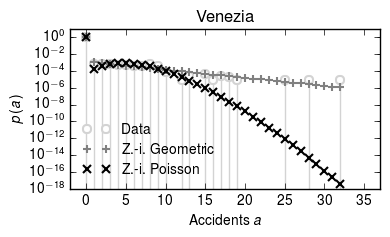

In [974]:
plot_accidents_pmf(df, city, 1, ms=6, mew=1.5)

Figure saved to file: venezia_zifit_9.pdf
Figure saved to file: venezia_zifit_9.png


(-0.5, 5.5)

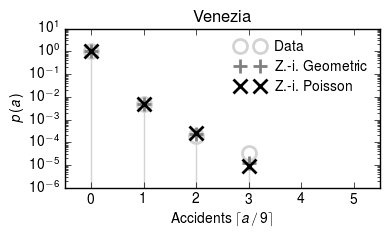

In [975]:
plot_accidents_pmf(df, city, 9, ms=10, mew=2)
xlim(-.5, xlim()[1] + .5)

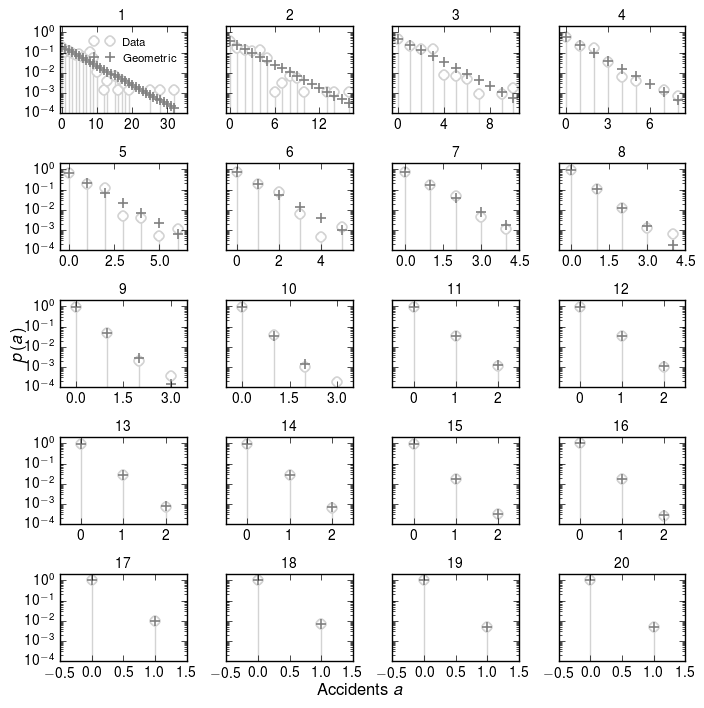

In [51]:
from scipy.stats import geom

city = 'palermo'

paths = getpaths(city, loc='data')
df = pandas.read_hdf(paths['store'], '/totals/{}'.format(city))

min_group_size = 1
max_group_size = 20
abserr = numpy.empty(max_group_size - min_group_size + 1)

n_plots = max_group_size - min_group_size + 1
nrows = int(numpy.ceil(numpy.sqrt(n_plots)))
ncols = int(numpy.floor(numpy.sqrt(n_plots)))
if nrows * ncols < n_plots:
    ncols += 1

fig, axs = subplots(nrows=nrows, ncols=ncols, figsize=(7, 7), sharey=True)
axs0 = numpy.ravel(axs)

for group_size, ax in zip(xrange(min_group_size, max_group_size + 1), axs0):
    
    # estimate zero-inflated Geometric on grouped data
    df_cleaned, zgtheta = clean_data(df, 'accidents', group_size=group_size)

    # fit again the cleaned with a simple Geometric (i.e. not inflated with zeros) and see it makes sense
    data = grouped_data_array(df_cleaned['accidents'].values, group_size)
    N = len(data)
    hatp = N / (data.sum() + N)
    
    # plot
    sca(ax)
    ret = plot_pmf(data, ('Geometric', geom(hatp, loc=-1)), ms=7, mew=1.2)
    title(city.title())
    yscale('log')
    ylim(ylim()[0], 2)
    xlim(-0.5, xlim()[1] + 0.5)
    title("{}".format(group_size), fontsize='medium')
    legend([], frameon=False)
    ax.get_xaxis().set_major_locator(MaxNLocator(4))
    
    # compute mean absolute error
    retdf = pandas.DataFrame(ret)
    abserr[group_size - min_group_size] = (retdf['data'] - retdf['geometric']).abs().mean()


fig.text(0.5, 0, r'Accidents $a$', transform=fig.transFigure,
        horizontalalignment='center', fontsize='large')
fig.text(0, 0.5, r'$p\left(a\,\right)$', transform=fig.transFigure, rotation=90, 
         verticalalignment='center', fontsize='large')

axs[0, 0].legend(frameon=False, loc='best', fontsize='small')

    
for ax in axs0[max_group_size - min_group_size + 1:]:
    delaxes(ax)
    
fig.tight_layout()

__NOTE__: you must evaluate the cell above before executing this one.

### Picking the best size for doing the grouping

Because the marginal distribution of accidents shows some kind of periodicity it is better to group the data prior to perform the fit of the zero-inflated model. This means that we introduce an implicit parameter for the size of the groups. One way to figure out the best size is to take a non-inflated model and check how good the fit with the cleaned data is. That is, we consider groups of increasing size. We group the data, estimate the zero-inflated model parameters $\pi$ and $p$, and estimate the number of excess zeros that can be removed. At this point the remaining data should follow the geometric distribution. In the plot below, to assess the goodness of fit, we use the mean absolute error of the probability mass function.

(0, 21)

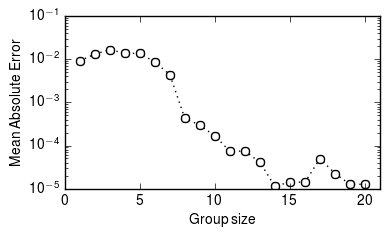

In [52]:
plot(numpy.arange(min_group_size, max_group_size + 1), abserr, 'ko:', mfc='w', mew=1.)
yscale('log')
xlabel("Group size")
ylabel("Mean Absolute Error")
xlim(0, max_group_size + 1)

### Non-cleaned

[  1.00000000e+00   1.78666635e+00   3.19217663e+00   5.70335455e+00
   1.01899916e+01   1.82061151e+01   3.25282532e+01   5.81171352e+01
   1.03835930e+02   1.85520161e+02   3.31462628e+02   5.92213122e+02
   1.05808725e+03   1.89044889e+03   3.37760140e+03   6.03464676e+03
   1.07819003e+04   1.92636584e+04   3.44177301e+04   6.14930000e+04]


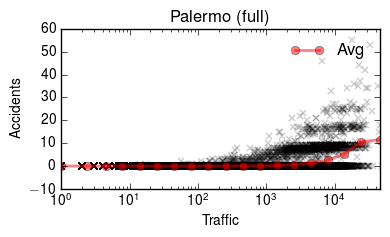

In [443]:
scatter_trips_accidents(df, "{} (full)".format(city.title()))

### Cleaned, random sampling 

[  1.00000000e+00   1.75952678e+00   3.09593449e+00   5.44737963e+00
   9.58481034e+00   1.68647305e+01   2.96739449e+01   5.22121007e+01
   9.18685893e+01   1.61645243e+02   2.84419134e+02   5.00443082e+02
   8.80543005e+02   1.54933900e+03   2.72610346e+03   4.79665203e+03
   8.43983770e+03   1.48501204e+04   2.61291846e+04   4.59750000e+04]


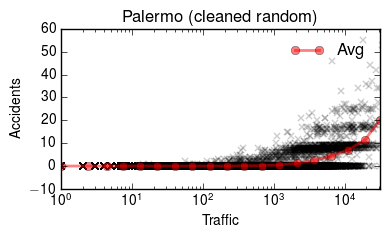

In [861]:
df_cleaned_random, __ = clean_data(df, 'accidents', group_size=group_size)
scatter_trips_accidents(df_cleaned_random, "{} (cleaned random)".format(city.title()))

### Cleaned, stratified sampling 

[  1.00000000e+00   1.78666635e+00   3.19217663e+00   5.70335455e+00
   1.01899916e+01   1.82061151e+01   3.25282532e+01   5.81171352e+01
   1.03835930e+02   1.85520161e+02   3.31462628e+02   5.92213122e+02
   1.05808725e+03   1.89044889e+03   3.37760140e+03   6.03464676e+03
   1.07819003e+04   1.92636584e+04   3.44177301e+04   6.14930000e+04]


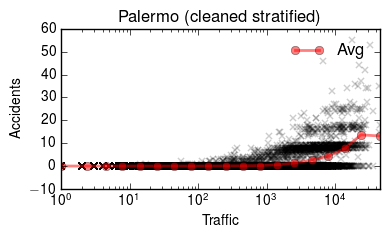

In [862]:
df_cleaned_strata, __ = clean_data(df, 'accidents', method='strata', group_size=group_size)
scatter_trips_accidents(df_cleaned_strata, "{} (cleaned stratified)".format(city.title()))

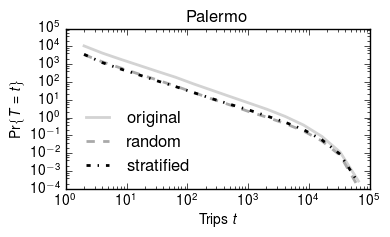

In [880]:
plot_pdf_log2(df['trips'], ls='-', marker='', color='LightGray', label='original', lw=2)
plot_pdf_log2(df_cleaned_random['trips'], ls='--', marker='', color='DarkGray', label='random', lw=2)
plot_pdf_log2(df_cleaned_strata['trips'], ls='-.', marker='', color='k', label='stratified', lw=2)
xlabel("Trips $t$")
ylabel("$\Pr\{T = t\}$")
legend(frameon=False, loc='best')
title(city.title())
#ylim(ylim()[0], 2)
tight_layout()

## Regression

Here we try to predict the number of accidents as a function of the trips and other predictors. We start by preparin the predictors:

In [12]:
import pandas
import numpy
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR

def shuffle_multiindex_frame(X, y):
    df = X.copy()
    df['_target'] = y
    index = numpy.asarray(list(df.index))
    idx = numpy.arange(len(index))
    numpy.random.shuffle(idx)
    index_shuffled = pandas.MultiIndex.from_tuples(map(tuple, index[idx]))
    df = df.reindex(index_shuffled)
    X = df[X.columns]
    y = df['_target']
    return X, y


def load_data_for_regression(city, frac=1.0, shuffle=False):
    paths = getpaths(city, loc='data')
    box = getbox(paths['boxes'], city)
    df = pandas.read_hdf(paths['store'], '/totals_cleaned/{}'.format(city))
    tweets = read_tweets(paths['tweets'], box)
    df = df.join(tweets).fillna(0).sample(frac=frac)
    df['log10trips'] = numpy.log10(df['trips'])
    y = df['accidents']
    X = df[['log10trips', 'speed', 'tweets']]
    if shuffle:
        X, y = shuffle_multiindex_frame(X, y)
    return X, y


def fit_model_and_plot(model, X, y, fit=True, print_error_scores=True, jitter=None):
    if fit:
        model.fit(X, y)
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    if print_error_scores:
        print 'Mean Absolute Error: {}'.format(mae)
        print 'Mean Squared Error: {}'.format(mse)
    if jitter is not None:
        h, k = numpy.random.randn(2, len(y)) * jitter
        scatter(y + h, y_pred + k, color='none', edgecolors='k')        
    else:
        scatter(y, y_pred, color='none', edgecolors='k')
    xlabel('True Accidents')
    ylabel('Predicted Accidents')
    u = (y.min(), y.max())
    plot(u, u, '--r')
    return mae, mse

Here we compare three models. These are: ordinary least squares (OLS) (the baseline); polynomial regression; and Support Vector Machines (SVM) with Radial Basis Function (RBF) kernels.

Mean Absolute Error: 2.18817361945
Mean Squared Error: 11.62659683
Mean Absolute Error: 1.65172216716
Mean Squared Error: 9.40794981345
Mean Absolute Error: 0.597352980343

/u/gciampag/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/u/gciampag/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



Mean Squared Error: 4.61691406467


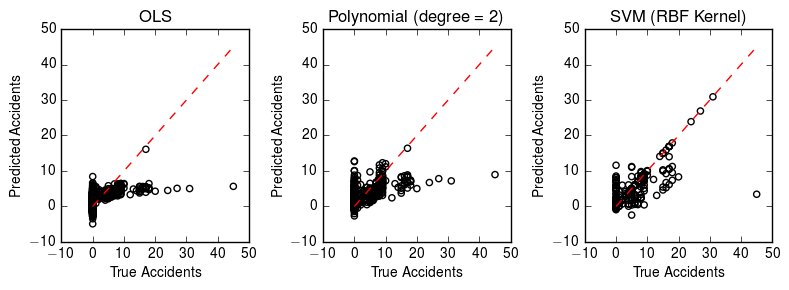

In [7]:
city = 'bari'
degree = 2

model0 = Pipeline([('standardized', StandardScaler()),
                   ('linear', LinearRegression(fit_intercept=True))])

model1 = Pipeline([('standardized', StandardScaler()),
                   ('polynomial', PolynomialFeatures(degree=degree)),
                   ('linear', LinearRegression(fit_intercept=True))])

#model2 = Pipeline([('standardized', StandardScaler()),
#                   ('SVR', SVR(kernel='rbf', epsilon=0.1 C=1e3, gamma=0.1))])

model2 = SVR(kernel='rbf', C=100, gamma=1)

X, y = load_data_for_regression(city, frac=0.1)

fig, axs = subplots(nrows=1, ncols=3, figsize=(8, 3))

sca(axs[0])
fit_model_and_plot(model0, X, y)
title('OLS')

sca(axs[1])
fit_model_and_plot(model1, X, y)
title('Polynomial (degree = {})'.format(degree))

sca(axs[2])
fit_model_and_plot(model2, X, y)
title('SVM (RBF Kernel)')
draw()

The following performs grid search to learn the best parameters for the SVM-RBF regression. The score is computed using K-fold cross-validation.

In [86]:
import os
import datetime
import logging

def rotatepath(path, use_ctime=False):
    """
    Rotate a path. If path exists, will rename it to a timestamped path of the form:
    
        <PATH>.<YYYYMMDD.HHMMSS>
    
    where YYYYMMDD.HHMMSS is either the file's MTIME (default) or CTIME (if use_ctime is set to True).
    
    If the new path already exists, appends an increasing integer:
    
        <PATH>.<YYYYMMDD.HHMMSS>.2
        <PATH>.<YYYYMMDD.HHMMSS>.3
    ...
    etc
    
    Will not rotate directories; instead, it will raise ValueError.
    """
    if os.path.exists(path):
        if os.path.isdir(path):
            raise ValueError("path is a dir: {}".format(path))
        s = os.stat(path)
        if use_ctime:
            ts = s.st_ctime
        else:
            ts = s.st_mtime
        t = datetime.datetime.fromtimestamp(ts)
        tag = t.strftime('%Y%m%d.%H%M%S')
        rpath = '{}.{}'.format(path, tag)
        cnt = 2
        while os.path.exists(rpath):
            rpath = '{}.{}'.format(rpath, cnt)
            cnt += 1
            print cnt
        os.rename(path, rpath)
        logging.info('Renamed {} to {}'.format(path, rpath))
    else:
        pass  # nothing to do


__WARNING!__: depending on the `frac` parameter passed to `load_data_for_regression` and on `C_range` and `gamma_range`, the following cell will take a lot to compute completely! Please tune `number_of_cores` to the number of cores/cpus your machine has.

2015-12-18 07:40:56,156: Completed: bari
2015-12-18 09:03:09,170: Completed: milano
2015-12-18 10:24:12,167: Completed: napoli
2015-12-18 10:28:55,518: Completed: palermo
2015-12-18 12:13:18,472: Completed: roma
2015-12-18 12:29:10,956: Completed: torino
2015-12-18 12:39:10,368: Completed: venezia
2015-12-18 12:39:10,380: All results saved to: /u/gciampag/data/tbdc15/cv_grid_results.json


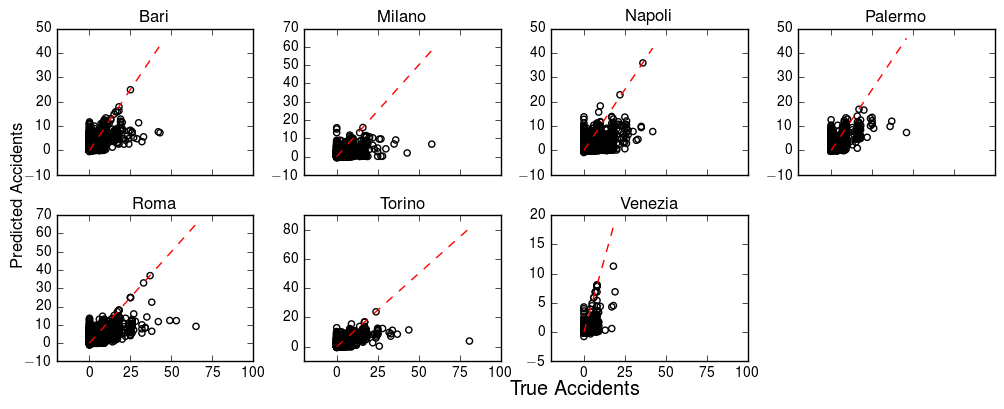

In [8]:
import numpy
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
import json

results_path = '/u/gciampag/data/tbdc15/cv_grid_results.json'

# ensure existing files are not overwritten!
rotatepath(results_path)

number_of_cores = 14  # run this on 16-core machine (smithers)
n_folds = 3

C_range = numpy.logspace(0, 4, num=5, base=10, endpoint=True)
gamma_range = numpy.logspace(-4, -1, num=7, base=10, endpoint=True)

model = SVR()
param_grid = [
  {'C': C_range, 'gamma': gamma_range, 'kernel': ['rbf']},
]

results = {}

fig, axs = subplots(nrows=2, ncols=4, figsize=(10, 4), sharex=True)
axs1d = numpy.ravel(axs)

for city, ax in zip(cities, axs1d):
    X, y = load_data_for_regression(city, frac=0.3)
    grid = GridSearchCV(model, param_grid, n_jobs=number_of_cores, cv=n_folds)
    grid.fit(X, y)
    sca(ax)
    mae, mse = fit_model_and_plot(grid.best_estimator_, X, y, fit=False, print_error_scores=False)
    title(city.title())

    results[city] = { 
        'params': grid.best_params_,
        'scores': {
            'R2': grid.best_score_,
            'MAE': mae,
            'MSE': mse
        }
    }
    logger.info('Completed: {}'.format(city))

with open(results_path, 'w') as fp:
    json.dump(results, fp)
logger.info('All results saved to: {}'.format(results_path))

for ax in axs1d[len(cities):]:
    delaxes(ax)

text(0.5, 0, 'True Accidents', fontsize='x-large', transform=fig.transFigure)
text(0, 0.5, 'Predicted Accidents', fontsize='large', rotation=90, 
     transform=fig.transFigure, verticalalignment='center')
axs1d[0].get_xaxis().set_major_locator(MaxNLocator(5))
tight_layout(pad=2.5, h_pad=0, w_pad=0)

# trick to ensure tight_layout leaves some space for labels added directly to the Figure object
for ax in axs1d[:len(cities)]:
    ax.set_xlabel("")
    ax.set_ylabel("")

### Assess the predictive power of tweets

In [340]:
import ujson
import numpy
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error

# SVM hyper-parameters obtained from cross-validated grid search
cv_grid_path = '/u/gciampag/data/tbdc15/cv_grid_results.json'

results_path = '/u/gciampag/data/tbdc15/cv_fit_results.json'
rotatepath(results_path)  # make sure existing data are not overwritten

scoring = 'r2'  
number_of_core = 14
n_folds = 5
cv_grid = ujson.load(open(cv_grid_path))
results = {}

for city in cities:
    X_df, y_df = load_data_for_regression(city, frac=1, shuffle=True)
    X = X_df.values.copy()
    y = y_df.values.copy()
    params = cv_grid[city]['params']
    params['kernel'] = str(params['kernel'])  # scikits-learn does not like unicode inputs...
    model = SVR(**params)
    # with tweets
    scores = cross_val_score(model, X, y, cv=n_folds, n_jobs=number_of_cores,
                            scoring=scoring)
    
    # w/o tweets
    del X_df['tweets']
    X = X_df.values.copy()
    scores_notweets = cross_val_score(model, X, y, cv=n_folds, n_jobs=number_of_cores, 
                                      scoring=scoring)
    
    # save results
    results[city] = {
        'scoring': scoring,
        'params': params,
        'score': scores.mean(),  
        'score_std': scores.std(),
        'score_notweets': scores_notweets.mean(),
        'score_notweets_std': scores_notweets.std(),
        'n_folds': n_folds,
    }
    logger.info('Completed: {}'.format(city))

with open(results_path, 'w') as fp:
    json.dump(results, fp)
logger.info('All results saved to: {}'.format(results_path))

2015-12-19 15:52:52,745: Renamed /u/gciampag/data/tbdc15/cv_fit_results.json to /u/gciampag/data/tbdc15/cv_fit_results.json.20151219.155124
2015-12-19 16:16:09,690: Completed: bari
2015-12-19 16:52:58,067: Completed: milano
2015-12-19 17:31:00,712: Completed: napoli
2015-12-19 17:31:55,117: Completed: palermo
2015-12-19 18:13:34,897: Completed: roma
2015-12-19 18:17:36,217: Completed: torino
2015-12-19 18:21:16,101: Completed: venezia
2015-12-19 18:21:16,112: All results saved to: /u/gciampag/data/tbdc15/cv_fit_results.json


In [341]:
results = ujson.load(open('/u/gciampag/data/tbdc15/cv_fit_results.json'))
d = dict((k, {'tweets': v['score'] , 'no_tweets': v['score_notweets']}) for k, v in results.iteritems())
pandas.DataFrame.from_dict(d, orient='index')

,tweets,no_tweets
bari,0.403003,0.426546
milano,0.285230,0.304241
napoli,0.300433,0.307589
palermo,0.530334,0.539719
roma,0.503515,0.524043
torino,0.490083,0.504793
venezia,0.190530,0.232743


## Try regression w/o aggregating on time / day of week 

This takes the raw data and cleans the data. It does so by selecting only the cells that are part of the `/totals_cleaned` dataframe.

In [51]:
city = 'bari'

def clean_longitudinal_data(city):
    """
    Take longitudinal traffic/accident data and clean them of zero-inflated cells.
    
    Store cleaned data frame to HDF store under path /longitudinal_cleaned/
    """
    # Read the raw data

    paths = getpaths(city, loc='data')
    df = pandas.read_hdf(paths['store'], '/{}'.format(city))
    df.head()

    # Read the cleaned aggregated data

    df_tot_cleaned = pandas.read_hdf(paths['store'], '/totals_cleaned/{}'.format(city))
    df_tot_cleaned.head()

    # Take only the cells in the cleaned data

    df_cleaned = df.set_index([df.i, df.j]).join(df_tot_cleaned, how='right', rsuffix='_tot').dropna()
    df_cleaned = df_cleaned.filter(df.columns)
    df_cleaned.head()

    # save to file

    df_cleaned.to_hdf(paths['store'], '/longitudinal_cleaned/{}'.format(city))

In [50]:
for city in cities:
    logger.info(city)
    clean_longitudinal_data(city)
    logger.info('{}: done'.format(city))

2016-01-28 22:21:47,372: bari
2016-01-28 22:25:24,202: bari: done
2016-01-28 22:25:24,204: milano
2016-01-28 22:37:13,169: milano: done
2016-01-28 22:37:13,171: napoli
2016-01-28 22:45:49,169: napoli: done
2016-01-28 22:45:49,170: palermo
2016-01-28 22:46:51,232: palermo: done
2016-01-28 22:46:51,233: roma
2016-01-28 22:51:54,567: roma: done
2016-01-28 22:51:54,568: torino
2016-01-28 22:53:54,184: torino: done
2016-01-28 22:53:54,185: venezia
2016-01-28 22:54:52,368: venezia: done


Create one datasets with all cities

In [180]:
df_all = []

frac = 5e-1

for city in cities:
    paths = getpaths(city, loc='data')
    df = pandas.read_hdf(paths['store'], '/longitudinal_cleaned/{}'.format(city))
    df['isweekend'] = df['weekday'] >= 5
    df['isdaytime'] = (df['hour'] > 6) & (df['hour'] <= 18)
    df = df.groupby(['i', 'j', 'isweekend', 'isdaytime'], as_index=False).agg({'speed': 'mean', 'trips': 'sum', 'accidents': 'sum'})
    s = df.groupby(['isdaytime', 'isweekend'])['accidents'].sum()
    df_accidents_tot = pandas.DataFrame({'accidents_tot': s})
    df = df.set_index(['isdaytime', 'isweekend']).join(df_accidents_tot)
    df['accidents_prob'] = df['accidents'] / df['accidents_tot']
    df.dropna(inplace=True)
    dfs = df.query('accidents > 0').sample(frac=frac)
    dfs = dfs.reset_index().set_index(['i', 'j'])
    dfs['city'] = city
    df_all.append(dfs)
    logger.info("{}: done".format(city))
    
    
df_all = pandas.concat(df_all)
logger.info('Total data: {}'.format(len(df_all)))

2016-04-27 17:57:04,319: bari: done
2016-04-27 17:58:27,973: milano: done
2016-04-27 18:00:59,421: napoli: done
2016-04-27 18:01:04,707: palermo: done
2016-04-27 18:01:23,383: roma: done
2016-04-27 18:01:32,903: torino: done
2016-04-27 18:01:37,224: venezia: done
2016-04-27 18:01:37,280: Total data: 10244


In [181]:
df_all.groupby('city').describe()

accidents  accidents_prob  accidents_tot isdaytime isweekend  \
city                                                                            
bari    count  1051.000000     1051.000000    1051.000000      1051      1051   
        mean      7.393911        0.001935    6009.599429  0.771646   0.32255   
        std       4.310223        0.001976    3334.267518  0.419972  0.467675   
        min       1.000000        0.000110     986.000000     False     False   
        25%       5.000000        0.000770    3539.000000         1         0   
        50%       8.000000        0.000990    9093.000000         1         0   
        75%       9.000000        0.002261    9093.000000         1         1   
        max      45.000000        0.014199    9093.000000      True      True   
milano  count  1838.000000     1838.000000    1838.000000      1838      1838   
        mean      6.311752        0.001081    9785.570185  0.820457   0.32481   
        std       3.721845        0.001327    5217.510360  0.383911  0.468431   
        min       1.000000        0.000070    1307.000000     False     False   
        25%       4.000000        0.000379    5493.000000         1         0   
        50%       6.000000        0.000634   14185.000000         1         0   
        75%       8.000000        0.001274   14185.000000         1         1   
        max      28.000000        0.014537   14185.000000      True      True   
napoli  count  2494.000000     2494.000000    2494.000000      2494      2494   
        mean      7.085806        0.000803   14006.733360  0.770249  0.315156   
        std       3.750953        0.000830    7755.450101  0.420757  0.464671   
        min       1.000000        0.000048    2829.000000     False     False   
        25%       5.000000        0.000334    8035.000000         1         0   
        50%       8.000000        0.000430   20933.000000         1         0   
        75%       9.000000        0.000996   20933.000000         1         1   
        max      35.000000        0.010251   20933.000000      True      True   
palermo count   675.000000      675.000000     675.000000       675       675   
        mean      7.764444        0.003051    4297.477037  0.798519  0.327407   
        std       4.094859        0.003430    2471.852251  0.401404  0.469615   
        min       1.000000        0.000154     752.000000     False     False   
        25%       6.000000        0.001231    2271.000000         1         0   
        50%       8.000000        0.001385    6497.000000         1         0   
        75%       9.000000        0.003523    6497.000000         1         1   
        max      37.000000        0.041998    6497.000000      True      True   
roma    count  2671.000000     2671.000000    2671.000000      2671      2671   
        mean      7.093598        0.000742   15800.375515  0.802696  0.318982   
        std       4.041943        0.000823    8833.442401  0.398039  0.466169   
        min       1.000000        0.000043    2200.000000     False     False   
        25%       5.000000        0.000298    8276.000000         1         0   
        50%       7.000000        0.000383   23475.000000         1         0   
        75%       9.000000        0.000967   23475.000000         1         1   
        max      36.000000        0.007727   23475.000000      True      True   
torino  count  1208.000000     1208.000000    1208.000000      1208      1208   
        mean      6.831954        0.001676    6894.648179  0.807119  0.331126   
        std       4.522327        0.001961    3833.575419  0.394724  0.470813   
        min       1.000000        0.000098     962.000000     False     False   
        25%       4.000000        0.000588    3773.000000         1         0   
        50%       7.000000        0.000882   10201.000000         1         0   
        75%       8.000000        0.002023   10201.000000         1         1   
        max      67.000000        0.016632   102

Mean Absolute Error: 0.00077978156583
Mean Squared Error: 3.59821852394e-06
Mean Absolute Error: 0.000490345415873
Mean Squared Error: 1.72257158269e-06
Mean Absolute Error: 0.0315074479758
Mean Squared Error: 0.000997190284904


/u/gciampag/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


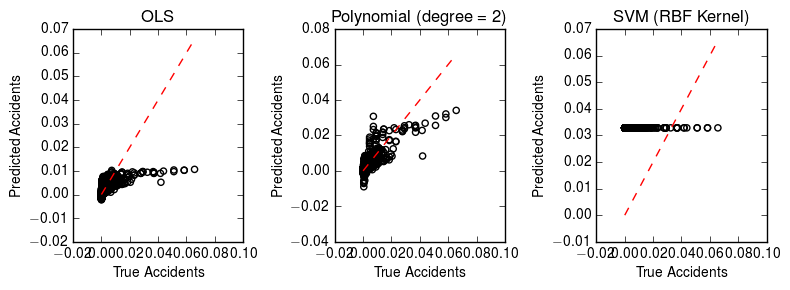

In [186]:
degree = 2

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

c = numpy.atleast_2d(df_all['city'].values).T
le = LabelEncoder()
le.fit(c)
idx = le.transform(c)
ohe = OneHotEncoder(sparse=False)
ohe.fit(idx)
C = ohe.transform(idx)
df_all['log10trips'] = numpy.log10(df_all['trips'])
y = df_all['accidents_prob']
X = numpy.c_[df_all[['log10trips', 'speed', 'isdaytime', 'isweekend']].astype(float), C]

model0 = Pipeline([('standardized', StandardScaler()),
                   ('linear', LinearRegression(fit_intercept=True))])

model1 = Pipeline([('standardized', StandardScaler()),
                   ('polynomial', PolynomialFeatures(degree=degree)),
                   ('linear', LinearRegression(fit_intercept=True))])

model2 = Pipeline([('standardized', StandardScaler()),
                   ('SVR', SVR(kernel='rbf', epsilon=0.1, C=1e3, gamma=0.1))])

model2 = SVR(kernel='rbf', C=100, gamma=1)

fig, axs = subplots(nrows=1, ncols=3, figsize=(8, 3))

sca(axs[0])
fit_model_and_plot(model0, X, y)
title('OLS')

sca(axs[1])
fit_model_and_plot(model1, X, y)
title('Polynomial (degree = {})'.format(degree))

sca(axs[2])
fit_model_and_plot(model2, X, y)
title('SVM (RBF Kernel)')
draw()

##  Initial test with regression

The following fits a Support Vector Machine for regression. The code is taken from the example page of scikits-learn.

580


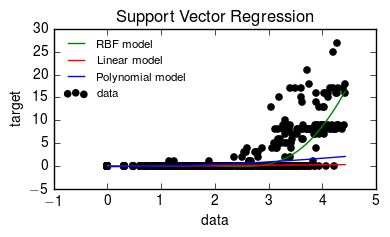

In [7]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

###############################################################################
# Generate sample data

xcol = 'trips'
ycol = 'accidents'
city = 'palermo'
paths = getpaths(city, loc='data')
df = pandas.read_hdf(paths['store'], '/totals_cleaned/{}'.format(city))
#emin = numpy.log10(df[xcol].min())
#emax = numpy.log10(df[xcol].max())
#bins = numpy.logspace(max(emin, 0), emax, 20)
#df = df.groupby(numpy.digitize(df[xcol], bins=bins)).mean()
_df = df.sample(frac=.1)
X = numpy.atleast_2d(numpy.log10(_df[xcol].values.copy())).T
y = _df[ycol].values.copy().ravel()
print len(_df)


#X = np.sort(5 * np.random.rand(40, 1), axis=0)
#y = np.sin(X).ravel()

###############################################################################
# Add noise to targets
#y[::5] += 3 * (0.5 - np.random.rand(8))

###############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

###############################################################################
# look at the results

idx = np.argsort(X, axis=0)[:, 0]
X = X[idx]
y = y[idx]
y_rbf = y_rbf[idx]
y_lin = y_lin[idx]
y_poly = y_poly[idx]
plt.scatter(X, y, c='k', label='data')
plt.hold('on')
plt.plot(X, y_rbf, c='g', label='RBF model')
plt.plot(X, y_lin, c='r', label='Linear model')
plt.plot(X, y_poly, c='b', label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend(fontsize='small', loc='best',frameon=False)
plt.show()
